<a href="https://colab.research.google.com/github/Astrocitos/Advanced-ML-Practices/blob/main/TC5033_Activity3a_ID40.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TC 5033
### Word Embeddings

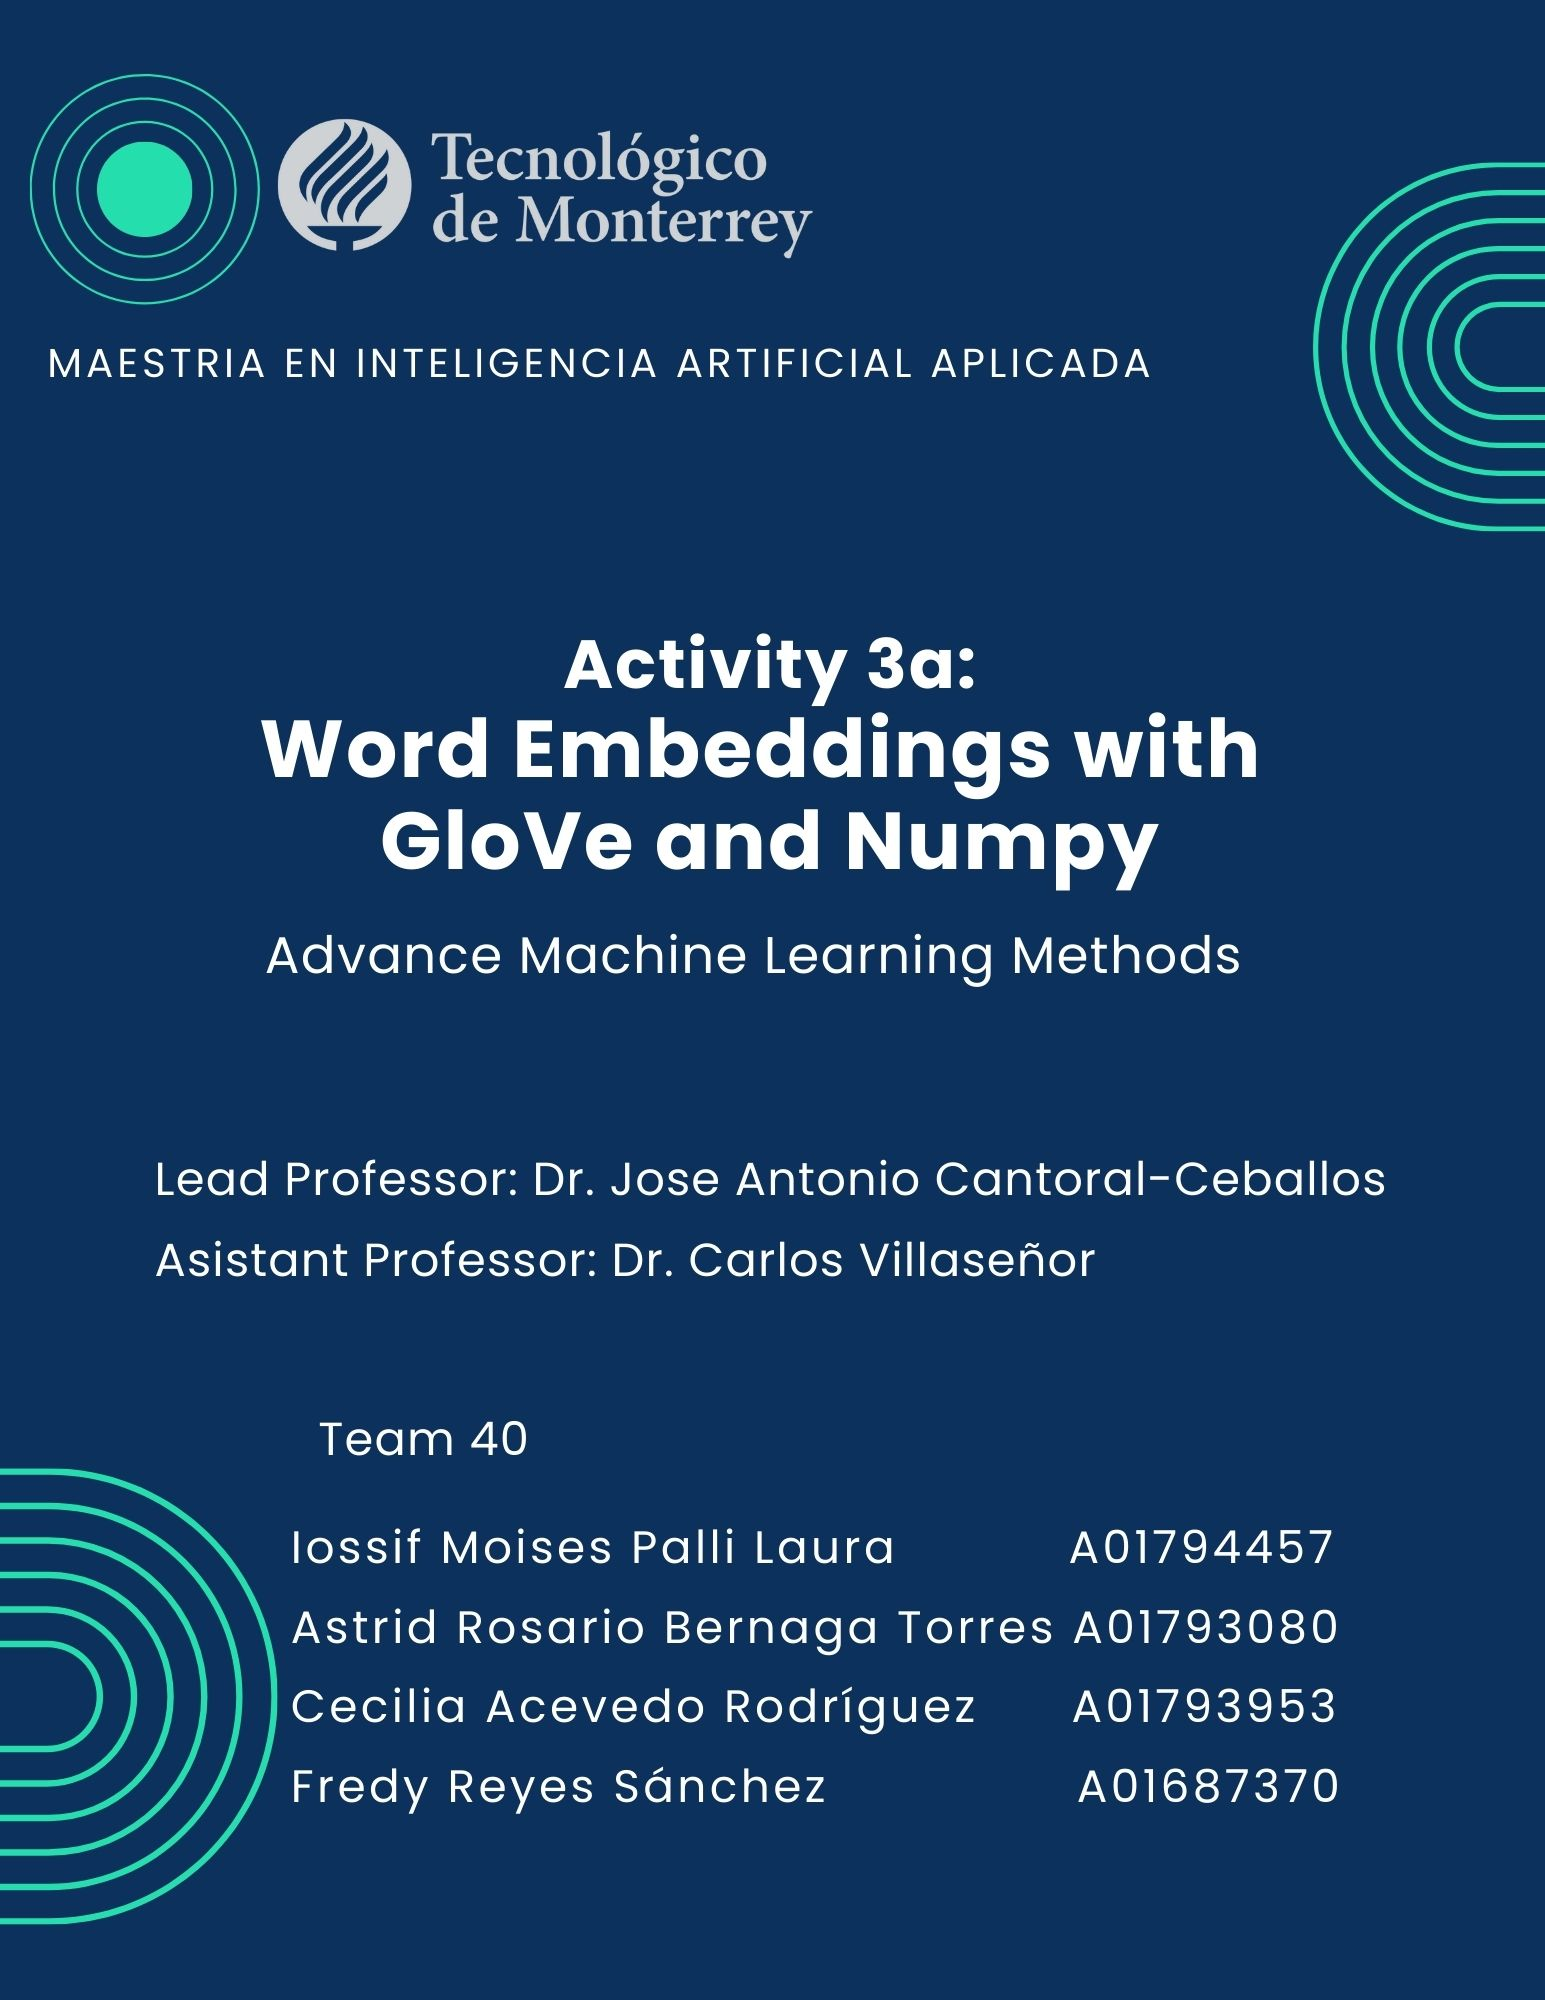

#### Activity 3a: Exploring Word Embeddings with GloVe and Numpy
<br>

- Objective:
    - To understand the concept of word embeddings and their significance in Natural Language Processing.
    - To learn how to manipulate and visualize high-dimensional data using dimensionality reduction techniques like PCA and t-SNE.
    - To gain hands-on experience in implementing word similarity and analogies using GloVe embeddings and Numpy.
    
<br>

- Instructions:
    - Download GloVe pre-trained vectors from the provided link in Canvas, the official public project:
    Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation
    https://nlp.stanford.edu/data/glove.6B.zip

    - Create a dictorionay of the embeddings so that you carry out fast look ups. Save that dictionary e.g. as a serialized file for faster loading in future uses.
    
    - PCA and t-SNE Visualization: After loading the GloVe embeddings, use Numpy and Sklearn to perform PCA and t-SNE to reduce the dimensionality of the embeddings and visualize them in a 2D or 3D space.

    - Word Similarity: Implement a function that takes a word as input and returns the 'n' most similar words based on their embeddings. You should use Numpy to implement this function, using libraries that already implement this function (e.g. Gensim) will result in zero points.

    - Word Analogies: Implement a function to solve analogies between words. For example, "man is to king as woman is to ____". You should use Numpy to implement this function, using libraries that already implement this function (e.g. Gensim) will result in zero points.

    - Submission: This activity is to be submitted in teams of 3 or 4. Only one person should submit the final work, with the full names of all team members included in a markdown cell at the beginning of the notebook.
    
<br>

- Evaluation Criteria:

    - Code Quality (40%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity.
    
   - Functionality (60%): All functions should work as intended, without errors.
       - Visualization of PCA and t-SNE (10% each for a total of 20%)
       - Similarity function (20%)
       - Analogy function (20%)
|



#Introduction
In this activity, we  involve into the world of Natural Language Processing (NLP) by exploring word embeddings, specifically using the GloVe (Global Vectors for Word Representation) model. Our aim is to visualize the complex relationships between words in a way that uncovers their semantic similarities. We'll leverage dimensionality reduction techniques such as PCA (Principal Component Analysis) and t-SNE (t-distributed Stochastic Neighbor Embedding) to project high-dimensional data onto a 2D plane, making it possible to perceive the nuanced groupings that exist within natural language. This process not only aids in the interpretation of word embeddings but also serves as a tool for validating the quality of our NLP models.

##Enviroment Setup

We begin by preparing our Google Colab environment, which provides the computational power necessary for handling large datasets and complex calculations.

###**Import libraries**

In [1]:
# Standard libraries
import numpy as np
import pickle

# Machine Learning
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Plotting and Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
plt.style.use('ggplot')

# PyTorch
import torch
import torch.nn.functional as F
from numpy.linalg import norm

###**Mounting Google Drive:**

To access the GloVe embeddings, we mount the Google Drive to our Colab environment, enabling us to load the data directly from our drive into the notebook.

 **Load file**

In [2]:
# Define PATH
PATH= '/content/drive/MyDrive/Tarea_3a/glove.6B.50d.txt'
emb_dim = 50

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

##Embeddings Dictionary Creation:
The GloVe embeddings, stored in a text file, are loaded and parsed into a Python dictionary where each word is linked to its corresponding high-dimensional vector.

In [5]:
# Create dictionary with embeddings
def create_emb_dictionary(path):
    embeddings_dict = {}
    with open(path, encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype="float32")
            embeddings_dict[word] = coefs
    return embeddings_dict

##**Embeddings Serialization:**
To speed up future access, we serialize the dictionary using Python's pickle module, allowing us to quickly load the pre-processed embeddings without repeating the initial parsing step.

In [6]:
try:
    with open('/content/drive/MyDrive/Tarea_3a/embeddings_dict_50D.pkl', 'rb') as f:
        embeddings_dict = pickle.load(f)
except FileNotFoundError:
    embeddings_dict = create_emb_dictionary(PATH)
    with open('/content/drive/MyDrive/Tarea_3a/embeddings_dict_50D.pkl', 'wb') as f:
        pickle.dump(embeddings_dict, f)

#### See some embeddings

In [7]:
# Function to display the first n words and their dimensions
def show_n_first_words(embeddings_dict, n_words):
    i = 0
    for word, vector in embeddings_dict.items():
        print(word, vector)
        i += 1
        if i >= n_words:
            break

In [8]:
show_n_first_words(embeddings_dict, 5)

the [ 4.1800e-01  2.4968e-01 -4.1242e-01  1.2170e-01  3.4527e-01 -4.4457e-02
 -4.9688e-01 -1.7862e-01 -6.6023e-04 -6.5660e-01  2.7843e-01 -1.4767e-01
 -5.5677e-01  1.4658e-01 -9.5095e-03  1.1658e-02  1.0204e-01 -1.2792e-01
 -8.4430e-01 -1.2181e-01 -1.6801e-02 -3.3279e-01 -1.5520e-01 -2.3131e-01
 -1.9181e-01 -1.8823e+00 -7.6746e-01  9.9051e-02 -4.2125e-01 -1.9526e-01
  4.0071e+00 -1.8594e-01 -5.2287e-01 -3.1681e-01  5.9213e-04  7.4449e-03
  1.7778e-01 -1.5897e-01  1.2041e-02 -5.4223e-02 -2.9871e-01 -1.5749e-01
 -3.4758e-01 -4.5637e-02 -4.4251e-01  1.8785e-01  2.7849e-03 -1.8411e-01
 -1.1514e-01 -7.8581e-01]
, [ 0.013441  0.23682  -0.16899   0.40951   0.63812   0.47709  -0.42852
 -0.55641  -0.364    -0.23938   0.13001  -0.063734 -0.39575  -0.48162
  0.23291   0.090201 -0.13324   0.078639 -0.41634  -0.15428   0.10068
  0.48891   0.31226  -0.1252   -0.037512 -1.5179    0.12612  -0.02442
 -0.042961 -0.28351   3.5416   -0.11956  -0.014533 -0.1499    0.21864
 -0.33412  -0.13872   0.31806   0.

In [9]:
words= ['burger', 'tortilla', 'bread', 'pizza', 'beef', 'steak', 'fries', 'chips',
            'argentina', 'mexico', 'spain', 'usa', 'france', 'italy', 'greece', 'china',
            'water', 'beer', 'tequila', 'wine', 'whisky', 'brandy', 'vodka', 'coffee', 'tea',
            'apple', 'banana', 'orange', 'lemon', 'grapefruit', 'grape', 'strawberry', 'raspberry',
            'school', 'work', 'university', 'highschool']


#Visualization

Using Matplotlib, we create a scatter plot to display the 2D points generated by t-SNE. We enhance the plot with a color map for better visual distinction between clusters and optionally annotate a subset of words to provide context.

### Plot some embeddings

In [10]:
def plot_embeddings(emb_path, words2show, emb_dim, embeddings_dict=None, method='PCA', num_clusters=None):

    if embeddings_dict is None:
        embeddings_dict = create_emb_dictionary(emb_path)

    words = list(embeddings_dict.keys())
    vectors = np.array(list(embeddings_dict.values()))

    # Perform KMeans clustering if num_clusters is provided
    if num_clusters is not None:
      kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=42)
      clusters = kmeans.fit_predict(vectors)
    else:
      clusters = np.arange(len(vectors))

    # Dimensionality reduction
    if method == 't-SNE':
        vectors_reduced = PCA(n_components=50).fit_transform(vectors)  # Speed up t-SNE with PCA
        result = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42, init='pca').fit_transform(vectors_reduced)
    elif method == 'PCA':
        result = PCA(n_components=2 if emb_dim == 3 else 2).fit_transform(vectors)

    # Plotting
    plt.figure(figsize=(15, 15))
    scatter = plt.scatter(result[:, 0], result[:, 1], alpha=0.5, c=clusters, cmap='viridis')

    # Annotate a subset of words to avoid clutter
    for word in words2show:
        if word in words:
            idx = words.index(word)
            plt.annotate(word, (result[idx, 0], result[idx, 1]), fontsize=12, alpha=0.7, color='red')

    plt.colorbar(scatter)
    plt.title(f'{method} Visualization of GloVe Embeddings (2D)')
    plt.show()

In [11]:
# Define some words to highlight in the visualization
words_to_show = ['king', 'queen', 'man', 'woman', 'paris', 'france', 'london', 'england', 'food', 'university', 'dog', 'cat']
words_to_show = [word for word in words_to_show if word in embeddings_dict]

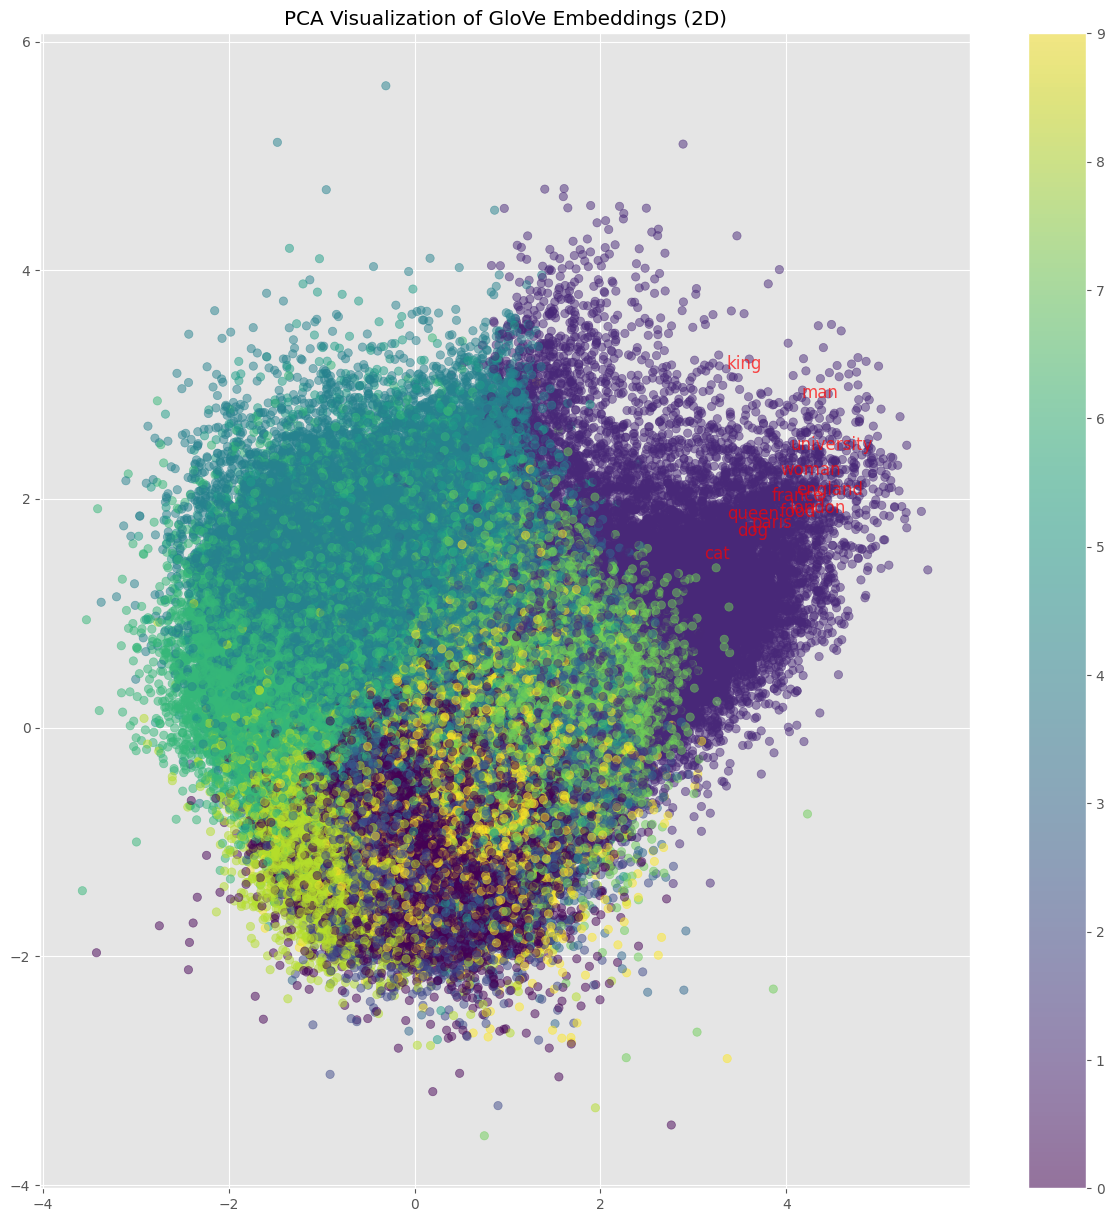

In [12]:
plot_embeddings(PATH, words_to_show, emb_dim=50, method='PCA', num_clusters=10)

 PCA  is a statistical technique used to emphasize variation and capture strong patterns in a dataset. In the context of word embeddings, it reduces the dimensions of the data while maintaining the relationships between words as much as possible.

**In this visualization:**

Each point represents a word in the high-dimensional GloVe embedding space, projected into two dimensions for visual clarity.

The color scale on the right likely represents the density of points or another metric, showing how concentrated or sparse the points are in different regions of the plot.

Words like "king," "man," "queen," "woman," "france," "england," "dog," and "cat" have been annotated in red, indicating their positions in the reduced space. These annotations help us understand which words are close to each other and may have similar contexts or meanings.

The clustering of points into different colors suggests that words that are semantically similar are grouped together. For example, "king" and "queen" or "france" and "england" appear close to each other, reflecting their semantic relationships.

In [ ]:
plot_embeddings(PATH, words_to_show, emb_dim=50, method='t-SNE', num_clusters=10)

### Let us compute analogies

In [ ]:
# Function to find the most similar vector to a given vector
def find_most_similar_vector(target_vector, embeddings_dict, exclude=None, top_n=1):
    similarities = {}
    for word, vector in embeddings_dict.items():
        if exclude is None or word not in exclude:
            similarities[word] = cosine_similarity(target_vector, vector)

    sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    return sorted_similarities[:top_n]

In [ ]:
# Define analogy function
def analogy(word1, word2, word3, embeddings_dict):
    if all(word in embeddings_dict for word in [word1, word2, word3]):
        vec1 = embeddings_dict[word1]
        vec2 = embeddings_dict[word2]
        vec3 = embeddings_dict[word3]

        # Compute the analogy vector
        analogy_vec = vec2 - vec1 + vec3

        # Find the word with the closest vector to the analogy vector
        closest_word = find_most_similar_vector(analogy_vec, embeddings_dict, exclude=[word1, word2, word3])

        return closest_word

    else:
        return "One or more words not found in embeddings dictionary."

In [ ]:
# Define a function to find the most similar words to a given word
def find_most_similar(word, embeddings_dict, top_n=10):
    if word in embeddings_dict:
        target_vector = embeddings_dict[word]

        # Find the most similar words based on cosine similarity
        similarities = {}
        for other_word, other_vector in embeddings_dict.items():
            if other_word != word:
                similarities[other_word] = cosine_similarity(target_vector, other_vector)

        # Sort the words by similarity and return the top_n
        sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
        return sorted_similarities[:top_n]

    else:
        return f"Word '{word}' not found in embeddings dictionary."

In [ ]:
# Function to compute cosine similarity between two vectors
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)

    similarity = dot_product / (norm_vec1 * norm_vec2)

    return similarity

In [ ]:
#Practice
if __name__ == "__main__":
    words_to_show = ['burger', 'tortilla', 'bread', 'pizza', 'beef', 'steak', 'fries', 'chips',
                     'argentina', 'mexico', 'spain', 'usa', 'france', 'italy', 'greece', 'china',
                     'water', 'beer', 'tequila', 'wine', 'whisky', 'brandy', 'vodka', 'coffee', 'tea',
                     'apple', 'banana', 'orange', 'lemon', 'grapefruit', 'grape', 'strawberry', 'raspberry',
                     'school', 'work', 'university', 'highschool']

In [ ]:
 # Visualize embeddings using t-SNE
 plot_embeddings(embeddings_dict, words_to_show, emb_dim, method='t-SNE')

In [ ]:
#Analogy example
analogy_result = analogy('man', 'king', 'woman', embeddings_dict)
print(f"Analogy: 'man' is to 'king' as 'woman' is to '{analogy_result}'")

Analogy: 'man' is to 'king' as 'woman' is to '[('queen', 0.86095816)]'


In [ ]:
# Most similar words example
most_similar_result = find_most_similar('mexico', embeddings_dict)
for i, (word, similarity) in enumerate(most_similar_result, 1):
    print(f'{i} ---> {word} (Similarity: {similarity:.4f})')

1 ---> mexican (Similarity: 0.8551)
2 ---> venezuela (Similarity: 0.8497)
3 ---> colombia (Similarity: 0.8490)
4 ---> peru (Similarity: 0.8446)
5 ---> chile (Similarity: 0.8439)
6 ---> puerto (Similarity: 0.8363)
7 ---> rico (Similarity: 0.8195)
8 ---> cuba (Similarity: 0.8125)
9 ---> guatemala (Similarity: 0.8114)
10 ---> panama (Similarity: 0.8097)


# Discussion

# Conclussion